Saving Customer Segmentation in E-commerce.csv to Customer Segmentation in E-commerce (2).csv


<ipython-input-4-3b31cb0a7036>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       691
           1       1.00      0.99      1.00       177

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



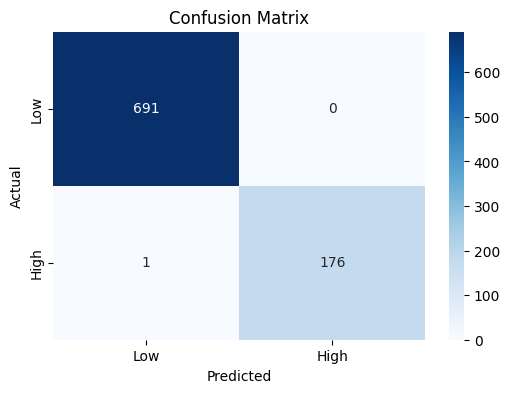

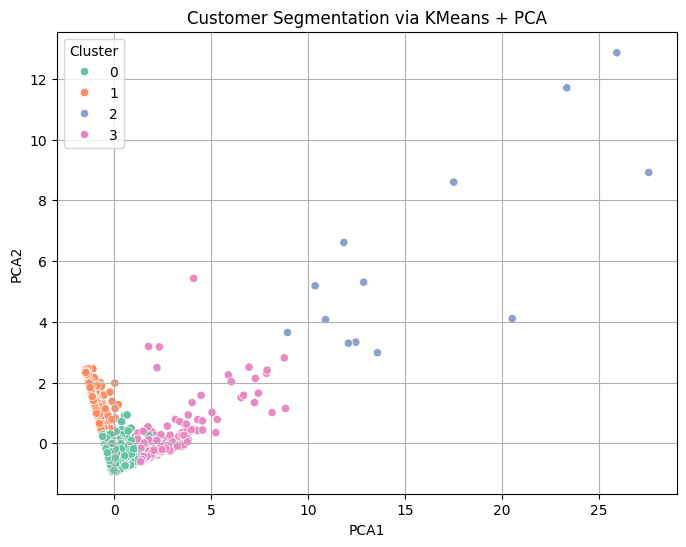

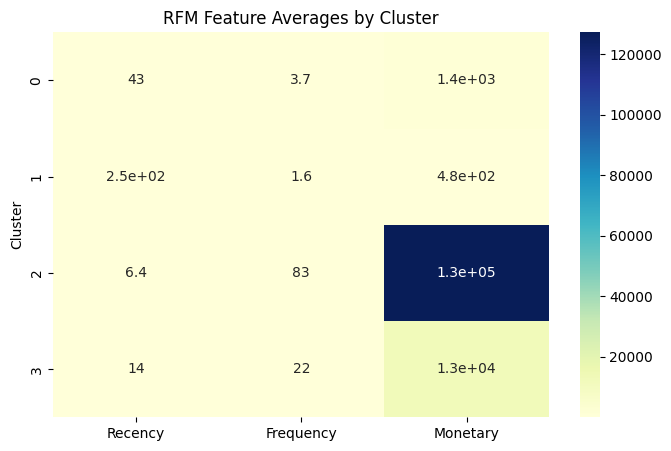

In [4]:
# 📌 Install packages
!pip install seaborn --quiet

# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 📂 Upload dataset
from google.colab import files
uploaded = files.upload()

# 🧹 Load and clean data
df = pd.read_csv("Customer Segmentation in E-commerce.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 📊 RFM features
ref_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# 🎯 Create classification label (Top 20% as High-Value Customers)
threshold = rfm['Monetary'].quantile(0.80)
rfm['HighValue'] = (rfm['Monetary'] >= threshold).astype(int)

# ⚙️ Scaling features
features = ['Recency', 'Frequency', 'Monetary']
X = rfm[features]
y = rfm['HighValue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🤖 Train classification model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 📈 Evaluation
print(classification_report(y_test, y_pred))

# 🔥 Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 🔗 KMeans Clustering (unsupervised)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaler.fit_transform(rfm[features]))

# 🎨 PCA for visualization
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(scaler.fit_transform(rfm[features]))
rfm['PCA1'] = pca_vals[:, 0]
rfm['PCA2'] = pca_vals[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segmentation via KMeans + PCA')
plt.grid(True)
plt.show()

# 🔥 RFM heatmap by cluster
cluster_summary = rfm.groupby('Cluster')[features].mean()
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu')
plt.title("RFM Feature Averages by Cluster")
plt.show()
